# CHAPTER 6: UNDERSTAND & EVALUATE YOUR MODELS

One major disadvantage of Machine Learning is the **black box problem**: you have the data input, your model (the black box), and the output, but you don't understand how the model interprets the inputs to produce the specific output. Additionally, each model behaves differently depending on the target you are using.  

For example, using **Mean Squared Error (MSE)** to evaluate a classification model won't lead to meaningful insights. More importantly, even standard metrics like **accuracy**, **F1-score**, or **precision** might not always provide the full picture. This is why it’s crucial to apply critical thinking to choose the most appropriate metrics to evaluate your model.

*PS: In short, we will create an ID card for our model, summarizing its strengths, weaknesses, and performance.*

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Signals import *
from FeaturesLibrary import *
import shap
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

In [2]:
# Import our dataset containing the features and the signals (already correctly shifted) 
df = pd.read_parquet("DATA/EURUSD_4H_dataset_signal_included.parquet")
df

,open,high,low,close,tick_volume,high_time,low_time,hurst,0_to_20,20_to_40,...,rolling_volatility_yang_zhang,linear_slope_6M,linear_slope_3M,linear_slope_1M,open_close_var,candle_color,next_candle_color,future_market_regime,labeling,dummy
time,,,,,,,,,,,,,,,,,,,,,
2014-11-14 00:00:00,1.24750,1.24789,1.24588,1.24665,14537.0,2014-11-14 00:12:00,2014-11-14 03:09:00,0.606340,12.446352,23.175966,...,NaN,NaN,NaN,NaN,-0.00085,0.0,0.0,NaN,-11.600000,0
2014-11-14 04:00:00,1.24665,1.24669,1.24266,1.24307,17128.0,2014-11-14 04:00:00,2014-11-14 07:46:00,0.710822,12.552301,12.970711,...,NaN,NaN,NaN,NaN,-0.00358,0.0,1.0,NaN,11.283333,1
2014-11-14 08:00:00,1.24306,1.24711,1.24262,1.24623,35033.0,2014-11-14 10:34:00,2014-11-14 08:04:00,0.583402,22.500000,15.000000,...,NaN,NaN,NaN,NaN,0.00317,1.0,0.0,NaN,-3.600000,0
2014-11-14 12:00:00,1.24614,1.24686,1.23982,1.24140,41784.0,2014-11-14 12:02:00,2014-11-14 15:36:00,0.593497,5.000000,7.500000,...,NaN,NaN,NaN,NaN,-0.00474,0.0,1.0,NaN,3.283333,1
2014-11-14 16:00:00,1.24140,1.25435,1.24054,1.25140,74087.0,2014-11-14 19:17:00,2014-11-14 16:05:00,0.682967,25.416667,11.250000,...,NaN,NaN,NaN,NaN,0.01000,1.0,1.0,NaN,56.583333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-12 20:00:00,1.06066,1.06263,1.06062,1.06227,6069.0,2024-11-12 23:05:00,2024-11-12 20:00:00,0.499964,6.276151,33.472803,...,0.002094,0.000022,-0.000122,-0.000109,0.00161,1.0,1.0,0.0,-17.133333,0
2024-11-13 00:00:00,1.06180,1.06288,1.06106,1.06277,4596.0,2024-11-13 03:46:00,2024-11-13 02:15:00,0.469370,16.595745,32.340426,...,0.002097,0.000022,-0.000123,-0.000113,0.00097,1.0,0.0,0.0,-13.133333,0
2024-11-13 04:00:00,1.06277,1.06290,1.06092,1.06127,3868.0,2024-11-13 04:00:00,2024-11-13 07:22:00,0.553327,7.916667,15.000000,...,0.002015,0.000021,-0.000124,-0.000117,-0.00150,0.0,1.0,0.0,-9.133333,0


In [3]:
list_X = ['hurst', 'market_regime', 'kama_diff', 'autocorr_20', 'autocorr_50', 'ret_log_10',
       'rolling_volatility_yang_zhang', 'linear_slope_6M', 'linear_slope_3M']
col_y = "dummy"

df_clean = df[list_X + [col_y]].dropna()
df_clean

# Clean before
X_train = df_clean.iloc[0:3_000,:][list_X]
y_train = df_clean.iloc[0:3_000,:][col_y]

X_test = df_clean.iloc[3_000:4_000,:][list_X]
y_test = df_clean.iloc[3_000:4_000,:][col_y]

In [4]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test) # WE DO NOT FIT THE MODEL ON THE TEST DATA ONLY ON THE TRAIN DATA

X_train_sc_df = pd.DataFrame(X_train_sc, columns=X_train.columns)
X_test_sc_df = pd.DataFrame(X_test_sc, columns=X_test.columns)

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle


model = VotingClassifier(
    estimators=[('lr', LogisticRegression()),
                ('svc', SVC(C=3)),
                ('rfc', RandomForestClassifier(n_estimators=1_000, max_depth=100, random_state=56)),
               ('ext', ExtraTreesClassifier(n_estimators=1_000, max_depth=None, min_samples_split=2, random_state=56)),
               ('bagsvc',BaggingClassifier(estimator=SVC(C=3),
                        n_estimators=10, random_state=56)),
               ('dnn', MLPClassifier(solver='adam', 
                    hidden_layer_sizes=(100, 20, 10), random_state=56))],
    voting='hard')

X_train_sc_shuffled, y_train_shuffled = shuffle(X_train_sc, y_train, random_state=56)

model.fit(X_train_sc_shuffled, y_train_shuffled)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', SVC(C=3)),
                             ('rfc',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=1000,
                                                     random_state=56)),
                             ('ext',
                              ExtraTreesClassifier(n_estimators=1000,
                                                   random_state=56)),
                             ('bagsvc',
                              BaggingClassifier(estimator=SVC(C=3),
                                                random_state=56)),
                             ('dnn',
                              MLPClassifier(hidden_layer_sizes=(100, 20, 10),
                                            random_state=56))])

<Axes: xlabel='time'>

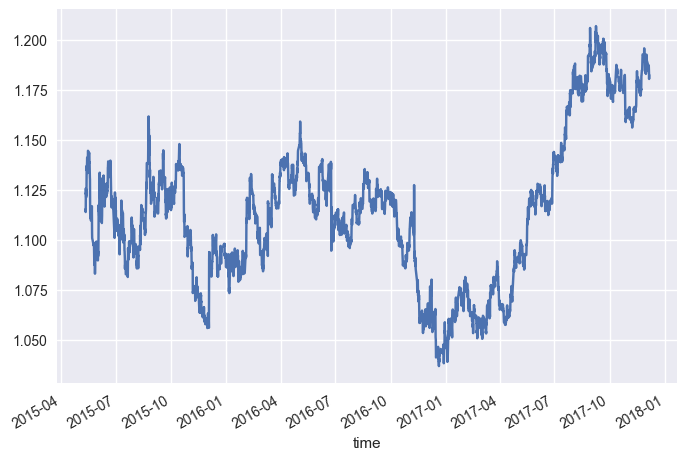

In [6]:
df[["close",'hurst', 'market_regime', 'kama_diff', 'autocorr_20', 'autocorr_50', 'ret_log_10',
       'rolling_volatility_yang_zhang', 'linear_slope_6M', 'linear_slope_3M']].dropna().iloc[:4_000,:]["close"].plot()

<br>

### 6.1. EVALUATE THE MODEL

Evaluating a model is **important**, but evaluating it with the **right features** is even better. For example, you don’t determine the winner of a basketball game by counting the number of players but by counting the points scored. Similarly, when working on a model that predicts whether to enter a buy position or not, what is the **most critical metric**?  

Is it **accuracy**, **precision for class 0 (do not enter)**, or **precision for class 1 (enter in buy)**? Of course, it’s **precision for class 1**, because if the model says "do not enter" and the price goes up, you miss a profit, but you don’t lose money either. However, if the model says "enter" and it’s wrong, you will **lose money**, which is far more significant.


In [7]:
X_test_sc_shuffled, y_test_shuffled = shuffle(X_test_sc, y_test, random_state=56)
y_pred = model.predict(X_test_sc_shuffled)
    
conf_matrix = confusion_matrix(y_test_shuffled, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

acc = accuracy_score(y_test_shuffled, y_pred)
print(f"\nAccuracy: {acc:.4f}")

precision_class_0 = 100 * conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
precision_class_1 = 100 * conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])

print(f"Precision Class 0: {precision_class_0:.2f} % \t Precision Class 1: {precision_class_1:.2f} %")

print(f"NB Prediction Class 0: {(conf_matrix[0][0] + conf_matrix[1][0])} \t NB Prediction Class 1: {(conf_matrix[1][1] + conf_matrix[0][1])}")

Confusion Matrix:
[[297  94]
 [438 171]]

Accuracy: 0.4680
Precision Class 0: 40.41 % 	 Precision Class 1: 64.53 %
NB Prediction Class 0: 735 	 NB Prediction Class 1: 265


In [8]:
y_pred = model.predict(X_test_sc)
    
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

acc = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.4f}")

precision_class_0 = 100 * conf_matrix[0][0] / (conf_matrix[0][0] + conf_matrix[1][0])
precision_class_1 = 100 * conf_matrix[1][1] / (conf_matrix[1][1] + conf_matrix[0][1])

print(f"Precision Class 0: {precision_class_0:.2f} % \t Precision Class 1: {precision_class_1:.2f} %")

print(f"NB Prediction Class 0: {(conf_matrix[0][0] + conf_matrix[1][0])} \t NB Prediction Class 1: {(conf_matrix[1][1] + conf_matrix[0][1])}")

Confusion Matrix:
[[297  94]
 [438 171]]

Accuracy: 0.4680
Precision Class 0: 40.41 % 	 Precision Class 1: 64.53 %
NB Prediction Class 0: 735 	 NB Prediction Class 1: 265


<br>

### 6.2. UNDERSTAND THE MODEL

In the previous section, we observed that our model performs well on the test set. However, the test set covers only an **8-month period with a strong upward trend**, which may not be representative of all market conditions.  

The goal now is to identify which variables have the **most significant impact** on the model's output and to perform a **quick (but not exhaustive) robustness check** of our Machine Learning model.

<br>

##### 6.2.1. Shapley Values

Shapley Values are a powerful tool from game theory used to explain how each feature contributes to a model's predictions. They calculate the **marginal contribution of each feature** by evaluating all possible combinations of feature subsets. This makes them particularly effective for understanding complex, non-linear models. 

Shapley Values provide **global insights** (feature importance over the entire dataset) and **local insights** (feature impact for a single prediction), but they can be computationally expensive, especially for large datasets or models with many features.


In [21]:
def shapley_graph(shap_values_bis):
    # Save the beeswarm plot
    plt.figure(figsize=(8, 6))
    shap.summary_plot(shap_values_bis, show=False)
    plt.savefig("IMAGES/beeswarm_plot.png", bbox_inches='tight')
    plt.close()
    
    # Save the bar plot
    plt.figure(figsize=(8, 6))
    shap.plots.bar(shap_values_bis, show=False)
    plt.savefig("IMAGES/bar_plot.png", bbox_inches='tight')
    plt.close()
    
    # Display both plots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    img1 = plt.imread("IMAGES/beeswarm_plot.png")  # Load the beeswarm plot
    img2 = plt.imread("IMAGES/bar_plot.png")  # Load the bar plot
    
    ax1.imshow(img1)  # Show the beeswarm plot
    ax1.axis('off')  # Remove axes
    ax2.imshow(img2)  # Show the bar plot
    ax2.axis('off')  # Remove axes
    plt.show()  # Display the side-by-side comparison

 98%|===================| 1961/2000 [00:31<00:00]        

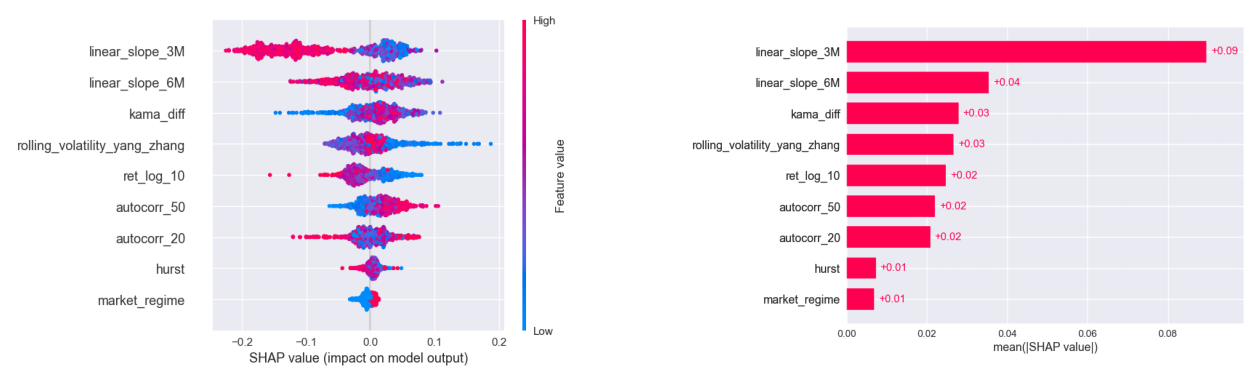

In [22]:
# Train the RandomForestClassifier model
model = RandomForestClassifier(random_state=56).fit(X_train_sc, y_train)

# Create a SHAP explainer using shap.Explainer and disable additivity check
explainer = shap.Explainer(model, X_train_sc_df)

# Compute SHAP values for X_test with check_additivity=False
shap_values = explainer(X_test_sc_df, check_additivity=False)

# Plot the graph
shapley_graph(shap_values[...,1])

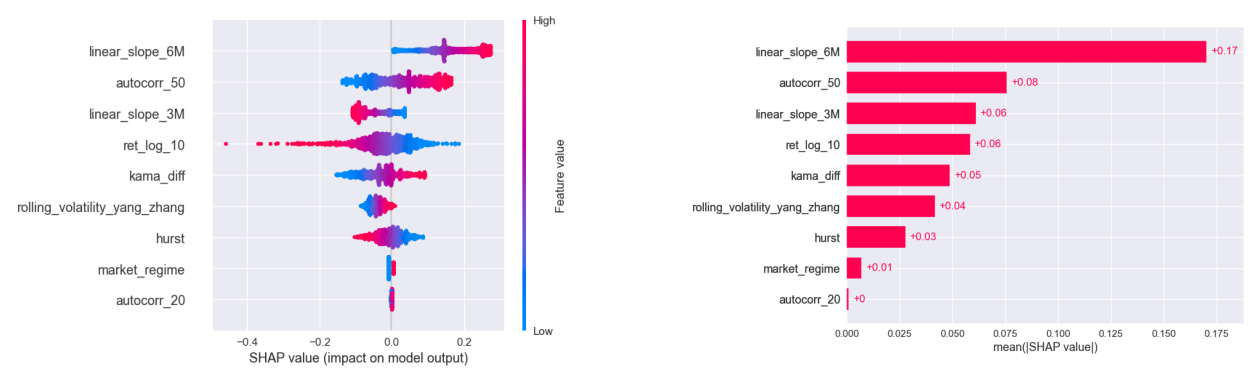

In [11]:
# Train the logistic regression model
model = LogisticRegression().fit(X_train_sc, y_train)

# Create a SHAP explainer for a linear model
explainer = shap.LinearExplainer(model, X_train_sc_df)

# Compute SHAP values for the test data
shap_values = explainer(X_test_sc_df)

shapley_graph(shap_values)

- The main variables (`linear_slope_6M`, `linear_slope_3M`, `kama_diff`) are consistent across both models, reinforcing their relevance in explaining the target.  
- Non-linear models capture additional information from variables like `rolling_volatility_yang_zhang` or `autocorr_20`, which are overlooked by the linear model.  
- In complex environments like trading, where non-linear relationships are common, the non-linear model can provide richer insights, although the linear model remains useful as a baseline.


<br>

##### 6.2.2. Cross Validation

Cross-validation is a robust technique used to evaluate a model's performance by splitting the dataset into **multiple folds**. The model is trained on some folds and validated on the remaining ones, ensuring that every part of the data is used for both training and testing.  

This method helps to identify **overfitting** or **underfitting** and provides a more reliable estimate of a model's performance compared to a single train-test split. However, it can be computationally expensive, especially for large datasets or complex models.


In [12]:
from sklearn.metrics import make_scorer, confusion_matrix, precision_score

# Function to calculate negative precision
def negative_precision_score(y_true, y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred)
    TN = conf_matrix[0][0]  # True Negatives
    FN = conf_matrix[1][0]  # False Negatives
    # Avoid division by zero
    if TN + FN == 0:
        return 0
    return TN / (TN + FN)

# Create scorers
negative_precision_scorer = make_scorer(negative_precision_score)
positive_precision_scorer = make_scorer(precision_score, pos_label=1)

In [13]:
clf = VotingClassifier(
    estimators=[('lr', LogisticRegression()),
                ('svc', SVC(C=3)),
                ('rfc', RandomForestClassifier(n_estimators=1_000, max_depth=100, random_state=56)),
               ('ext', ExtraTreesClassifier(n_estimators=1_000, max_depth=None, min_samples_split=2, random_state=56)),
               ('bagsvc',BaggingClassifier(estimator=SVC(C=3),
                        n_estimators=10, random_state=56)),
               ('dnn', MLPClassifier(solver='adam', 
                    hidden_layer_sizes=(100, 20, 10), random_state=56))],
    voting='hard')

In [14]:
from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# TimeSeriesSplit cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Create a pipeline with the scaler and the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', clf)
])

# Define scoring metrics
scoring = {
    'positive_precision': positive_precision_scorer,  # Precision for the positive class
    'negative_precision': negative_precision_scorer  # Precision for the negative class
}

# Perform cross-validation with the pipeline
X = df_clean.iloc[0:4_000,:][list_X]
y = df_clean.iloc[0:4_000,:][col_y]
results = cross_validate(pipeline, X, y, cv=tscv, scoring=scoring)

# Display results
print("Positive Precision Scores:", results['test_positive_precision'])
print("Negative Precision Scores:", results['test_negative_precision'])
print("Mean Positive Precision:", results['test_positive_precision'].mean())
print("Mean Negative Precision:", results['test_negative_precision'].mean())


Positive Precision Scores: [0.37777778 0.57894737 0.46907216 0.54006969 0.62557078]
Negative Precision Scores: [0.46743295 0.45050505 0.57913669 0.41688654 0.43176734]
Mean Positive Precision: 0.5182875547628283
Mean Negative Precision: 0.4691457145374659


In [15]:
# K-Fold cross-validation with 10 splits, no shuffling
kf = KFold(n_splits=10, shuffle=False)

# Perform cross-validation with the pipeline
scores = cross_validate(pipeline, X, y, cv=kf, scoring=scoring)

# Display results
print("Positive Precision Scores:", scores['test_positive_precision'])
print("Negative Precision Scores:", scores['test_negative_precision'])
print("Mean Positive Precision:", scores['test_positive_precision'].mean())
print("Mean Negative Precision:", scores['test_negative_precision'].mean())

Positive Precision Scores: [0.40833333 0.4744898  0.47826087 0.51101322 0.66666667 0.38289963
 0.39411765 0.54166667 0.59821429 0.54333333]
Negative Precision Scores: [0.5        0.5        0.47402597 0.49710983 0.54455446 0.45801527
 0.57826087 0.3046875  0.3125     0.56      ]
Mean Positive Precision: 0.49989954423685123
Mean Negative Precision: 0.4729153892801904


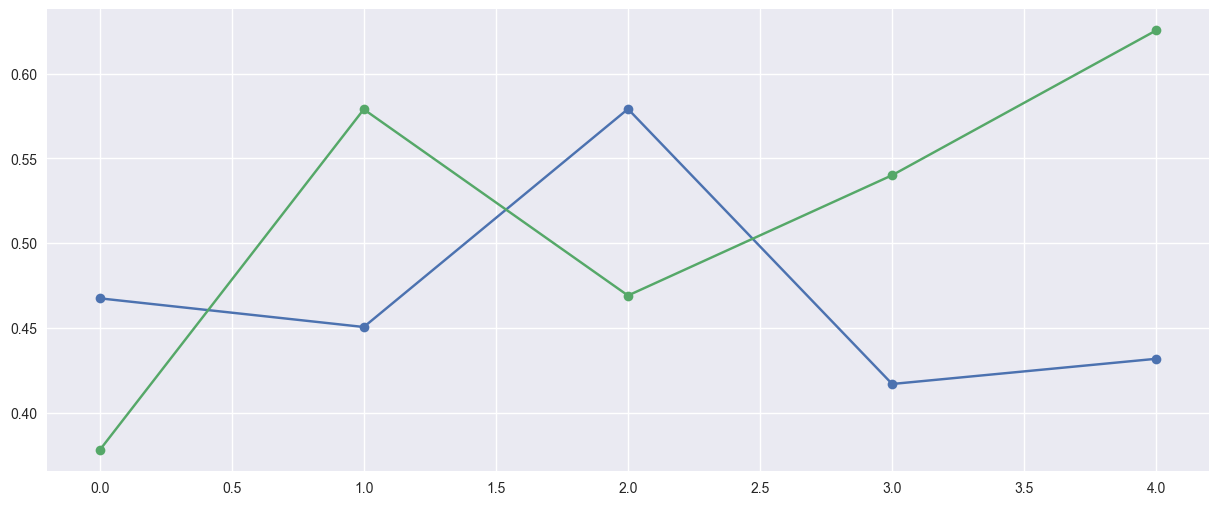

,SELL PRECISION,BUY PRECISION
SELL PRECISION,1.00000,-0.45731
BUY PRECISION,-0.45731,1.00000


In [16]:
# Create a DataFrame
df_res = pd.DataFrame([results['test_negative_precision'], results['test_positive_precision']], index=["SELL PRECISION", "BUY PRECISION"]).transpose()

# Plot the results
plt.figure(figsize=(15,6))
plt.plot(df_res, "o-")
plt.show()

# Compute the correlation
df_res.corr()

<br>

##### 6.2.3. Specific Analysis

Evaluating and understanding a model can be done using **generic methods** like **accuracy** or **Shapley values**, but you can often go **deeper** in your analysis. The challenge is that the **deeper you go, the less automation** is possible, making this process more manual and time-consuming.  

This approach **requires significant effort for each signal**, but it can yield **valuable insights** that generic methods might overlook.


In [17]:
# We re-create the model as we call the previous models model too
model = VotingClassifier(
    estimators=[('lr', LogisticRegression()),
                ('svc', SVC(C=3)),
                ('rfc', RandomForestClassifier(n_estimators=1_000, max_depth=100, random_state=56)),
               ('ext', ExtraTreesClassifier(n_estimators=1_000, max_depth=None, min_samples_split=2, random_state=56)),
               ('bagsvc',BaggingClassifier(estimator=SVC(C=3),
                        n_estimators=10, random_state=56)),
               ('dnn', MLPClassifier(solver='adam', alpha=3.16e-5,
                    hidden_layer_sizes=(100, 20), random_state=56))],
    voting='hard')

# We shuffle for the iteration models (not necessary)
X_train_sc_shuffled, y_train_shuffled = shuffle(X_train_sc, y_train, random_state=56)

# Train the model
model.fit(X_train_sc_shuffled, y_train_shuffled)

VotingClassifier(estimators=[('lr', LogisticRegression()), ('svc', SVC(C=3)),
                             ('rfc',
                              RandomForestClassifier(max_depth=100,
                                                     n_estimators=1000,
                                                     random_state=56)),
                             ('ext',
                              ExtraTreesClassifier(n_estimators=1000,
                                                   random_state=56)),
                             ('bagsvc',
                              BaggingClassifier(estimator=SVC(C=3),
                                                random_state=56)),
                             ('dnn',
                              MLPClassifier(alpha=3.16e-05,
                                            hidden_layer_sizes=(100, 20),
                                            random_state=56))])

In [18]:
# Do the prediction
dfr = pd.DataFrame(y_test)
y_pred = model.predict(X_test_sc)
dfr["prediction"] = y_pred
dfr

,dummy,prediction
time,,
2017-04-17 08:00:00,1,1
2017-04-17 12:00:00,1,1
2017-04-17 16:00:00,1,1
2017-04-17 20:00:00,1,1
2017-04-18 00:00:00,1,1
...,...,...
2017-12-05 04:00:00,0,1
2017-12-05 08:00:00,0,1
2017-12-05 12:00:00,0,1


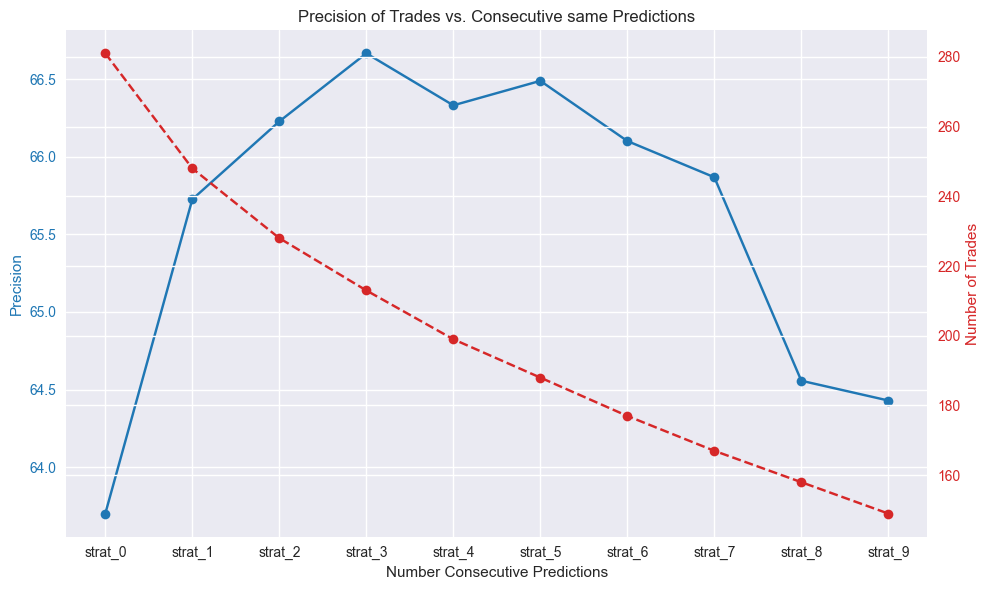

In [19]:
def apply_strategy(df, n_shifts, value_if_true, value_if_false, target_column='strat3'):
    # Generate the dynamic condition for the shifts
    conditions = [(df["prediction"].shift(i) == 1) for i in range(n_shifts, 0, -1)]
    conditions.append(df["prediction"] == 1)
    combined_condition = conditions[0]
    
    for condition in conditions[1:]:
        combined_condition &= condition
    
    # Apply the strategy based on the combined condition
    df.loc[combined_condition & (df["dummy"] == 1), target_column] = value_if_true
    df.loc[combined_condition & (df["dummy"] == 0), target_column] = value_if_false

    
for i in range(10):
    apply_strategy(dfr, n_shifts=i, value_if_true=1, value_if_false=0, target_column=f"strat_{i}")

pnl = pd.DataFrame(dfr.mean().iloc[2:]*100, columns=["Precision"]).transpose()
nbt = pd.DataFrame((len(dfr) - dfr.isnull().sum().iloc[2:]), columns=["Number of Trades"]).transpose()
res = pd.concat((pnl,nbt), axis=0).transpose()

# Create the DataFrame
data = {
    'strat': [f'strat_{i}' for i in range(10)],
    'Precision': res["Precision"],
    'Number of Trades': res["Number of Trades"]
}

df = pd.DataFrame(data)

# Create the figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the first data series (Average P&L/trade)
color = 'tab:blue'
ax1.set_xlabel('Number Consecutive Predictions')
ax1.set_ylabel('Precision', color=color)
ax1.plot(df['Precision'], color=color, marker='o', label='Average P&L/trade')
ax1.tick_params(axis='y', labelcolor=color)

# Create the second axis for the number of trades
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Number of Trades', color=color)
ax2.plot(df['Number of Trades'], color=color, marker='o', linestyle='--', label='Number of Trades')
ax2.tick_params(axis='y', labelcolor=color)

# Add a title and display the legend
plt.title('Precision of Trades vs. Consecutive same Predictions')
fig.tight_layout()

# Display the chart
plt.show()

<br>

### 6.3. Trading Signal Analysis

Finally, we see that this **signal is not really good**. There is no clear reason to continue further. On our test set, we had **70% precision**, which is **amazing**. However, thanks to our **cross-validation**, we observed that when incorporating **different market conditions** during training, the predictions become **less accurate**, with an **average negative precision (class 0)** of **50%** and inconsistent positive precision (class 1). In other words, the **market is too complex** to be understood this way by our models.  

One solution to fix this problem is to **condition your analysis**. Instead of using all the data for training, you select a **well-chosen subset** of data. This method can be applied to **literally everything**, but here are some practical examples:  

- **Condition your analysis** to observations where the **RSI is above 70**  
- **Condition your analysis** to observations with a **huge price movement** in the N previous candles  
- **Condition your analysis** to observations that satisfy a **specific chart pattern setup**  